# AAE with no pretraining: Performance evaluation

Jacqueline R. M. A. Maasch | May 2022

## Preamble

In [1]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle
from rdkit import Chem                                                                                                                                                                   
from rdkit import RDLogger 
from random import sample
import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [2]:
# View versioning.
print("\npython version:", sys.version)
print("\n--- LIBRARY VERSIONS ---")
print("tdc:         ", version("PyTDC"))
print("numpy:       ", version("numpy"))
print("pandas:      ", version("pandas"))
print("moses:       ", version("molsets"))
print("rdkit:       ", version("rdkit-pypi"))
print("scipy:       ", version("scipy"))
print("seaborn:     ", version("seaborn"))
print("matplotlib:  ", version("matplotlib"))


python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]

--- LIBRARY VERSIONS ---
tdc:          0.3.6
numpy:        1.22.3
pandas:       1.2.4
moses:        0.3.1
rdkit:        2021.9.5.1
scipy:        1.7.2
seaborn:      0.11.1
matplotlib:   3.3.4


In [3]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [4]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    # Disable warnings.
    RDLogger.DisableLog("rdApp.*")  
    
    # Filter molecules.
    keep = []
    invalid_string = 0
    invalid_chemistry = 0
    for molecule in generated:
        m = Chem.MolFromSmiles(molecule, sanitize = False)
        if m is None:
            invalid_string += 1
        else:
            try:
                Chem.SanitizeMol(m)
                keep.append(molecule)
            except:
                invalid_chemistry += 1
                
    print("Total strings with invalid SMILES syntax:", invalid_string)
    print("Total strings with invalid chemistry:", invalid_chemistry)
    print("Total valid SMILES strings:", len(keep))
    print("Percent valid SMILES strings:", (len(keep) / len(generated)))
    
    return keep


def plot_distribution_basic(df, 
                            log_x = None, 
                            log_y = None, 
                            save_path = "./plt.pdf", 
                            save = False):
    
    sns.displot(data = df, 
                x = "Value", 
                hue = "Distribution", 
                col = "Metric",
                kind = "kde", 
                log_scale = (log_x, log_y),
                common_norm = True,
                fill = True,
                height = 5)
    if save:
        plt.savefig(save_path)
    else:
        plt.show()
    
    
def plot_distribution(df, 
                      log_x = None, 
                      log_y = None, 
                      save_path = "./plt.pdf", 
                      save = False):
    
    g = sns.FacetGrid(df.reset_index(), 
                      col = "Metric",
                      hue = "Distribution", 
                      sharex = False, 
                      sharey = False)
    g.map_dataframe(sns.kdeplot, 
                    "Value",
                    fill = True, 
                    log_scale = (log_x, log_y),
                    common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [5]:
# Read in generated molecules.
df_active = pd.read_csv("../aae/generated_molecules_100k/gen_active_finetune_100k.csv")
df_inactive = pd.read_csv("../aae/generated_molecules_100k/gen_inactive_finetune_100k.csv")

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,CN(C)CCCN1c2ccccc2Sc2ccccc23-c1cncnc1<pad><pad...
1,Cc1sc(=O)[[nH]2cccc122CCN(C(=O)CCl)CC1)c1c2cn(...
2,Cc1[nH]ccc1C2CCN(C(=O)CCl)CC1)C2<pad><pad><pad...
3,OCC1(c2ccccn2)CCCC1<pad><pad><pad><pad><pad><p...
4,COc1ccccc1CNC(C)C(C)OCCC(=O)C(C)(C)C<pad><pad>...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,C1COCCN1c1ccc(Cl)cc1<pad><pad><pad><pad><pad><...
1,CC(NS(=O)(=O)c1ccc(O)cc1)NC1=NCN(CCO)C(=O)CN<p...
2,C[CB<unk>]1CN[C<unk><unk>H]2c3ccccc3CCC(N)=O<u...
3,COc1cc(N2CCOCC2)c(OC)c2c1cnc2[n<unk>]1c1cccc(F...
4,Cc1nc2ccc(F)cc2n[nH]1<pad><pad><pad><pad><pad>...


### Training data from TDC

In [6]:
df_active_train = pd.read_csv("../sars_data/actives_train.csv")
df_inactive_train = pd.read_csv("../sars_data/inactives_train.csv")

print(df_active_train.info())
display(df_active_train.head())
print(df_inactive_train.info())
display(df_inactive_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  132 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
None


,SMILES
0,NC(=O)c1ccc(NC(=O)[C@@H]2CCCO2)cc1
1,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
2,COC(=O)Nc1sc(C)nc1-c1ccccc1
3,OC1CCN(Cc2ccsc2)CC1
4,CC(C(O)c1ccc(O)cc1)N1CCC(Cc2ccccc2)CC1.CC(C(O)...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1758 non-null   object
dtypes: object(1)
memory usage: 13.9+ KB
None


,SMILES
0,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1
1,COc1cc(Br)c(C[N+]2(CCOCCC3CCC4CC3C4(C)C)CCOCC2...
2,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1
3,COCC1=C(C(=O)OC(C)OC(=O)OC(C)C)N2C(=O)[C@@H](N...
4,c1nc(N2CCC2)c2[nH]cnc2n1


### Validation data

In [7]:
df_active_val = pd.read_csv("../sars_data/actives_val.csv")
df_inactive_val = pd.read_csv("../sars_data/inactives_val.csv")

print(df_active_val.info())
display(df_active_val.head())
print(df_inactive_val.info())
display(df_inactive_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  34 non-null     object
dtypes: object(1)
memory usage: 400.0+ bytes
None


,SMILES
0,O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1
1,O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1
2,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...
3,C/C=C/c1ccc(OC)cc1
4,Clc1cccc(CN2CCOCC2)c1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  440 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB
None


,SMILES
0,CCC1(C)CC(=O)NC1=O
1,CC(=O)N[C@@H](CCC(N)=O)C(=O)O
2,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O
3,CC(C)n1cnc(S(N)(=O)=O)c1
4,Cc1ccc(=O)n(-c2ccccc2)c1


## Process data

In [8]:
# Remove padding.
remove_pad = lambda x: x.replace("<pad>", "")
df_active.SMILES = df_active.SMILES.map(remove_pad)
df_inactive.SMILES = df_inactive.SMILES.map(remove_pad)

In [9]:
# Listify.
actives_gen = list(df_active.SMILES)
inactives_gen = list(df_inactive.SMILES)

actives_train = list(df_active_train.SMILES)
inactives_train = list(df_inactive_train.SMILES)

actives_val = list(df_active_val.SMILES)
inactives_val = list(df_inactive_val.SMILES)

In [10]:
# Filter out molecules that do not pass RDKit checks.
# Some metrics will require this step.
print("--- de novo actives ---")
actives_gen_grammatical = remove_ungrammatical(actives_gen)
print("\n--- de novo inactives ---")
inactives_gen_grammatical = remove_ungrammatical(inactives_gen)
print("\n--- training actives ---")
actives_train_grammatical = remove_ungrammatical(actives_train)
print("\n--- training inactives ---")
inactives_train_grammatical = remove_ungrammatical(inactives_train)
print("\n--- validation actives ---")
actives_val_grammatical = remove_ungrammatical(actives_val)
print("\n--- validation inactives ---")
inactives_val_grammatical = remove_ungrammatical(inactives_val)

--- de novo actives ---
Total strings with invalid SMILES syntax: 52131
Total strings with invalid chemistry: 7297
Total valid SMILES strings: 40572
Percent valid SMILES strings: 0.40572

--- de novo inactives ---
Total strings with invalid SMILES syntax: 63495
Total strings with invalid chemistry: 5203
Total valid SMILES strings: 31302
Percent valid SMILES strings: 0.31302

--- training actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 132
Percent valid SMILES strings: 1.0

--- training inactives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 1758
Percent valid SMILES strings: 1.0

--- validation actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 34
Percent valid SMILES strings: 1.0

--- validation inactives ---
Total strings with invalid SMILES syntax: 0
Total strings wit

## Global-level metrics

### MOSES metrics

In [11]:
moses.get_all_metrics?

Signature:
moses.get_all_metrics(
    gen,
    k=None,
    n_jobs=1,
    device='cpu',
    batch_size=512,
    pool=None,
    test=None,
    test_scaffolds=None,
    ptest=None,
    ptest_scaffolds=None,
    train=None,
)
Docstring:
Computes all available metrics between test (scaffold test)
and generated sets of SMILES.
Parameters:
    gen: list of generated SMILES
    k: int or list with values for unique@k. Will calculate number of
        unique molecules in the first k molecules. Default [1000, 10000]
    n_jobs: number of workers for parallel processing
    device: 'cpu' or 'cuda:n', where n is GPU device number
    batch_size: batch size for FCD metric
    pool: optional multiprocessing pool to use for parallelization

    test (None or list): test SMILES. If None, will load
        a default test set
    test_scaffolds (None or list): scaffold test SMILES. If None, will
        load a default scaffold test set
    ptest (None or dict): precalculated statistics of the test set. 

In [12]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = actives_gen, train = actives_train, test = actives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 1824.1145498752594 seconds.


{'valid': 0.40561,
 'unique@1000': 0.795,
 'unique@10000': 0.6456,
 'FCD/Test': 27.731477221782583,
 'SNN/Test': 0.26568331194929534,
 'Frag/Test': 0.7513167000007519,
 'Scaf/Test': 0.17295211640984975,
 'FCD/TestSF': 12.606457723016646,
 'SNN/TestSF': 0.4908132280029579,
 'Frag/TestSF': 0.8844874533709745,
 'Scaf/TestSF': 0.21355807330359056,
 'IntDiv': 0.8647058488019307,
 'IntDiv2': 0.8471251846154894,
 'Filters': 0.7852370503685806,
 'logP': 0.5326188731351622,
 'SA': 0.5739626341799797,
 'QED': 0.11139110358950138,
 'weight': 97.28311777395564,
 'Novelty': 0.9965445749827229}

In [13]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = inactives_gen, train = inactives_train, test = inactives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 1769.4673569202423 seconds.


{'valid': 0.31294999999999995,
 'unique@1000': 0.981,
 'unique@10000': 0.9,
 'FCD/Test': 7.357704096392801,
 'SNN/Test': 0.3326266378774956,
 'Frag/Test': 0.9248819135019402,
 'Scaf/Test': 0.23595537622884688,
 'FCD/TestSF': 8.505827850033754,
 'SNN/TestSF': 0.45681772872134224,
 'Frag/TestSF': 0.9227287686476084,
 'Scaf/TestSF': 0.12700935413779202,
 'IntDiv': 0.8800330380505298,
 'IntDiv2': 0.8687070661258735,
 'Filters': 0.9354849017414922,
 'logP': 0.5609151000159771,
 'SA': 0.47981750801262657,
 'QED': 0.08960402809584411,
 'weight': 90.33732731666406,
 'Novelty': 0.9920118680817072}

### TDC metrics

In [14]:
# NOTE: must subsample generative inactives to < 10k to get TDC functions to work.
# This is due to a glitch in TDC.
actives_gen_grammatical_10k = sample(actives_gen_grammatical, 10000)
inactives_gen_grammatical_10k = sample(inactives_gen_grammatical, 10000)

In [15]:
%%capture
# Throws error.
'''
ompute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen_grammatical, actives_train_grammatical)
'''

In [16]:
# KL divergence of active generated data and active training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_gen_grammatical_10k, actives_train_grammatical)

RDKit ERROR: [10:23:13] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:23:13] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:23:37] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:23:37] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:23:42] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:23:42] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:23:44] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:23:44] Explicit valence for atom # 1 O, 3, is greater than permitted


0.5425133962360658

In [17]:
%%capture
# Throws error.
'''
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen_grammatical_10k, inactives_train_grammatical)
'''

In [18]:
# KL divergence of inactive generated data and inactive training data.
kl(inactives_gen_grammatical_10k, inactives_train_grammatical)

RDKit ERROR: [10:24:25] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:24:25] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:24:35] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:24:35] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:25:03] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:25:03] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:25:03] Explicit valence for atom # 2 O, 3, is greater than permitted


0.6586387843979673

In [19]:
# KL divergence of active training data and inactive training data.
kl(actives_train_grammatical, inactives_train_grammatical)

0.854377160131264

In [20]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen_grammatical_10k, inactives_train_grammatical)

RDKit ERROR: [10:25:32] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:25:32] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:25:58] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:25:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:26:17] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:26:17] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:26:20] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:26:20] Explicit valence for atom # 1 O, 3, is greater than permitted


0.5543583321313578

In [21]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen_grammatical_10k, actives_train_grammatical)

RDKit ERROR: [10:27:08] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:27:08] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:27:14] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:27:14] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:27:42] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:27:42] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:27:42] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:27:42] Explicit valence for atom # 2 O, 3, is greater than permitted


0.6364758134328496

In [22]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen_grammatical_10k, inactives_gen_grammatical_10k)

RDKit ERROR: [10:28:18] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:28:18] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:28:43] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:28:43] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:28:51] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:28:51] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:28:55] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:28:55] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:29:13] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:29:13] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:29:13] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:29:13] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:29:33] Explicit valence for

0.9298249250435345

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [23]:
# Synthetic accessibility.
sa = Oracle(name = "SA")

'''
sa_actives_gen = sa(actives_gen_grammatical)
sa_inactives_gen = sa(inactives_gen_grammatical)
sa_actives_train = sa(actives_train_grammatical)
sa_inactives_train = sa(inactives_train_grammatical)
'''

invalid = 0
sa_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_gen))

invalid = 0
sa_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_gen))

invalid = 0
sa_actives_train = []
for molecule in actives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_train))

invalid = 0
sa_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_train))

print()
sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Found local copy...



Total invalid: 0
Total valid: 40572

Total invalid: 0
Total valid: 31302

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[2.444174567822591, 3.1297156045707855, 1.6954951532691265, 2.342270593665903, 3.4433566567611464, 2.3306837967471967, 2.3279506013213993, 2.7064180846242323, 3.062761469453859, 1.8098447186399245, 1.6358716390096664, 1.7274231070995612, 1.8961222887689537, 3.3955761676560243, 1.7691135383843353, 2.09852586660144, 1.4468635255155569, 2.1677879030440668, 1.9605035049174795, 1.5359575087690605] 

Generated inactives :
[1.5480842844217833, 2.8673298605977227, 2.419538259554404, 2.293584751435393, 1.341038050426306, 2.4544270941963404, 1.5605150192781299, 1.8793987418021416, 2.736657272145761, 2.1485060129798814, 2.145383586524078, 1.7257251893055248, 1.659452704098424, 2.0535680286049214, 3.6394786751571964, 3.059952225902707, 2.216545453447207, 1.943327222536297, 2.970738104231158, 2.859794489739338] 

Training actives :
[2.

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [24]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
inactives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in inactives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            inactives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo inactives with invalid valence:", invalid_valence)
print("Total de novo inactives with valid valence:", len(inactives_gen_grammatical_keep))

RDKit ERROR: [10:34:41] Explicit valence for atom # 3 C, 5, is greater than permitted
[10:34:41] Explicit valence for atom # 3 C, 5, is greater than permitted
RDKit ERROR: [10:34:42] Explicit valence for atom # 5 O, 3, is greater than permitted
[10:34:42] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [10:34:43] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:34:43] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:34:43] Explicit valence for atom # 20 O, 3, is greater than permitted
[10:34:43] Explicit valence for atom # 20 O, 3, is greater than permitted
RDKit ERROR: [10:34:43] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:34:43] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [10:34:43] Explicit valence for atom # 2 O, 3, is greater than permitted
[10:34:43] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [10:34:46] Explicit valence f

Total de novo inactives with invalid valence: 7
Total de novo inactives with valid valence: 31295


In [25]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
actives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in actives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            actives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo actives with invalid valence:", invalid_valence)
print("Total de novo actives with valid valence:", len(actives_gen_grammatical_keep))

RDKit ERROR: [10:34:46] Explicit valence for atom # 10 O, 3, is greater than permitted
[10:34:46] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [10:34:46] Explicit valence for atom # 7 O, 3, is greater than permitted
[10:34:46] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [10:34:47] Explicit valence for atom # 19 O, 3, is greater than permitted
[10:34:47] Explicit valence for atom # 19 O, 3, is greater than permitted
RDKit ERROR: [10:34:47] Explicit valence for atom # 16 N, 4, is greater than permitted
[10:34:47] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [10:34:48] Explicit valence for atom # 8 N, 4, is greater than permitted
[10:34:48] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [10:34:48] Explicit valence for atom # 1 O, 3, is greater than permitted
[10:34:48] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [10:34:51] Explicit valence

Total de novo actives with invalid valence: 11
Total de novo actives with valid valence: 40561


RDKit ERROR: [10:34:53] Explicit valence for atom # 10 O, 3, is greater than permitted
[10:34:53] Explicit valence for atom # 10 O, 3, is greater than permitted


In [26]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(actives_gen_grammatical_keep) # Use only instances with proper valence.
qed_inactives_gen = qed(inactives_gen_grammatical_keep) # Use only instances with proper valence.
qed_actives_train = qed(actives_train_grammatical)
qed_inactives_train = qed(inactives_train_grammatical)

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.7479000983432343, 0.7549789814289362, 0.8429558284125275, 0.71928733891081, 0.6805712090403054, 0.7966938884685433, 0.6873315858365848, 0.6252894461585413, 0.8972367998127379, 0.6643597093746845, 0.7492757379129593, 0.8051508186652733, 0.7700287737415117, 0.7573740343801906, 0.82974293831983, 0.8624568583368762, 0.8514183278143493, 0.8523133036484695, 0.8276225869504602, 0.7097425790327138] 

Generated inactives :
[0.6844899707937704, 0.8613664081769815, 0.7492890253322193, 0.9144967991928986, 0.9019419607683181, 0.8916717246912137, 0.4977389538763361, 0.90172352412661, 0.8508443023346441, 0.9001918587268495, 0.510750401683258, 0.7862286741176217, 0.767416929183716, 0.49686122883962447, 0.8816185004985413, 0.581466982005081, 0.6698782643754385, 0.38433532808549475, 0.8526041286300394, 0.49504575471533896] 

Training actives :
[0.814913995911437, 0.7209997551181787, 0.8867424621741485, 0.7798427952514674, 0.08557107474966161, 0.7958887434961184, 0.6113669325066001

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [27]:
# LogP.
logp = Oracle(name = "LogP")

'''
logp_actives_gen = logp(actives_gen_grammatical)
logp_inactives_gen = logp(inactives_gen_grammatical)
logp_actives_train = logp(actives_train_grammatical)
logp_inactives_train = logp(inactives_train_grammatical)
'''

invalid = 0
logp_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_gen))

invalid = 0
logp_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_gen))

invalid = 0
logp_actives_train = []
for molecule in actives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_train))

invalid = 0
logp_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_train))

print()
logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 40572

Total invalid: 0
Total valid: 31302

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[0.5013627846177093, 0.8627310762662794, 1.1563396580534797, -0.2178911016371553, -0.07751247339913286, 0.36045685574798736, -3.3474665919771462, -0.26322663787214484, 0.26581927244124026, -0.3696700797183188, 2.076410657114741, 2.3231177593308585, 1.7714308806858643, -1.1930754658551308, 1.8849037872905205, 1.1689196524193122, 2.1803938353525325, 0.18219288723411298, 0.9042021363123875, 0.3603640459920372] 

Generated inactives :
[1.7792426581983252, 0.5342377526697576, 0.6193934180999225, 0.8273248283054762, 2.662087326669616, 0.526501747796936, 1.287170685172046, 1.1755530722457062, 0.3996250389707771, -2.410852342054468, -0.25783769337997264, 2.633313821407835, 2.7566763254158064, -0.34457091086926006, -0.10720396734668991, 1.039294332967041, 2.221967075967593, -0.19251141839867003, -0.12674601787568307, -1.41260320011

### Dictionary to dataframe

In [28]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_sa["Metric"] = "SA"
display(df_sa)

,Distribution,Value,Metric
0,Generated actives,2.444175,SA
1,Generated actives,3.129716,SA
2,Generated actives,1.695495,SA
3,Generated actives,2.342271,SA
4,Generated actives,3.443357,SA
...,...,...,...
1753,Training inactives,1.919343,SA
1754,Training inactives,2.494935,SA
1755,Training inactives,4.908138,SA
1756,Training inactives,2.417861,SA


In [29]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_qed["Metric"] = "QED"
display(df_qed)

,Distribution,Value,Metric
0,Generated actives,0.747900,QED
1,Generated actives,0.754979,QED
2,Generated actives,0.842956,QED
3,Generated actives,0.719287,QED
4,Generated actives,0.680571,QED
...,...,...,...
1753,Training inactives,0.736693,QED
1754,Training inactives,0.877740,QED
1755,Training inactives,0.675608,QED
1756,Training inactives,0.834182,QED


In [30]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

,Distribution,Value,Metric
0,Generated actives,0.501363,LogP
1,Generated actives,0.862731,LogP
2,Generated actives,1.156340,LogP
3,Generated actives,-0.217891,LogP
4,Generated actives,-0.077512,LogP
...,...,...,...
1753,Training inactives,1.354121,LogP
1754,Training inactives,1.682860,LogP
1755,Training inactives,-1.982381,LogP
1756,Training inactives,0.699492,LogP


In [31]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221274 entries, 0 to 221273
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Distribution  221274 non-null  object 
 1   Value         221274 non-null  float64
 2   Metric        221274 non-null  object 
dtypes: float64(1), object(2)
memory usage: 5.1+ MB
None


,Distribution,Value,Metric
0,Generated actives,2.444175,SA
1,Generated actives,3.129716,SA
2,Generated actives,1.695495,SA
3,Generated actives,2.342271,SA
4,Generated actives,3.443357,SA
...,...,...,...
221269,Training inactives,1.354121,LogP
221270,Training inactives,1.682860,LogP
221271,Training inactives,-1.982381,LogP
221272,Training inactives,0.699492,LogP


## Plot distributions

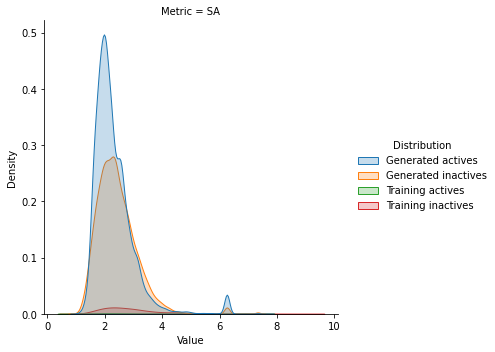

In [32]:
plot_distribution_basic(df_sa)

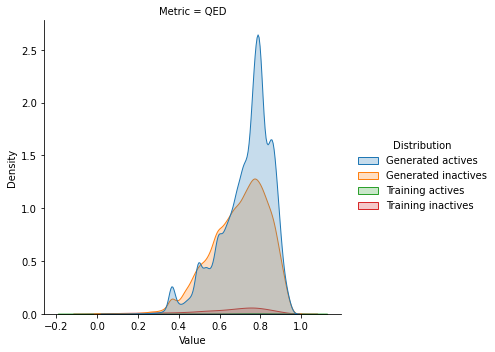

In [33]:
plot_distribution_basic(df_qed)

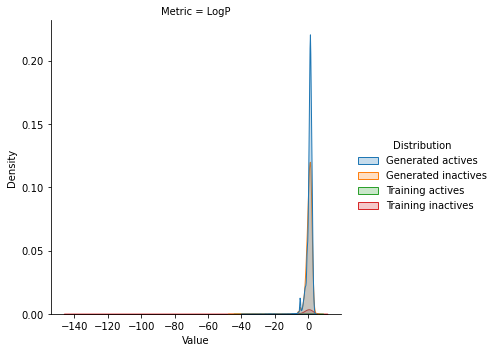

In [34]:
plot_distribution_basic(df_logp)

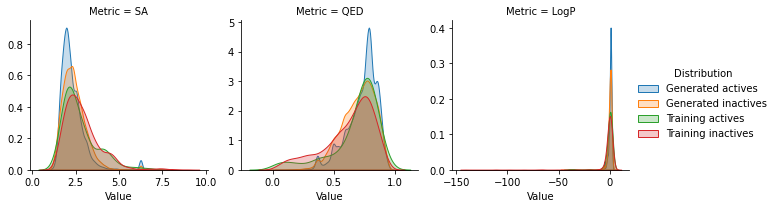

In [35]:
plot_distribution(df_metrics, save_path = "./aae_finetune_100k_metrics.pdf", save = True)

## End of document